# Experiments with Telco Churn data

This notebook demonstrates how to build a ML model for telco churn prediction. 
The data used is from this kaggle data set: https://www.kaggle.com/blastchar/telco-customer-churn
As this notebook is part of a bigger workshop We assume that you already have this data loaded on a gs://{project_id} location

We are going to build a basic model using sklearn. The purpose is to experiment with feature engineering and try few models to pick the best. 
Once we are happy with the processing and model building parts of our code, we are going to create a package of our code and execute this on AI platform training service.

!The packageing and execution to AI Platform is not part of this notebook!

In [2]:
# importing all necessary modules needed for our ML process

#import google.auth
import dask.dataframe as dd
from google.cloud import bigquery, bigquery_storage
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
import pickle
from google.cloud import storage
from datetime import datetime
import os
import pandas as pd
import logging
import numpy as np
from typing import Union, List
import json

Here we set the PROJECT variable to our project id. The project id can be found on your GCP console but the following automates the process by getting the value from !gcloud config get-value project 

In [31]:
PROJECT=!gcloud config get-value project # returns default project id 
PROJECT=PROJECT[0]

BUCKET = "gs://"+PROJECT

DATA_GCS_LOCATION = BUCKET+"/telco-churn/data/data_v1.csv"
DATA_BQ_URI = 'bq://'+PROJECT+'.telco.churn'

JOB_TIMESTAMP = datetime.now().strftime('%Y%m%d-%H%M%S') # Creating timestamp so that every execution of the notebook writes to a unique gs location

MODEL_DIR = BUCKET+"/telco-churn/experiment-"+JOB_TIMESTAMP # adding the timestamp to the model_dir path.
                                                        # This path is used to write assets like the trained model and job report

In [ ]:
#!pip install google-cloud-aiplatform

## Loading data from Google Cloud Storage (GCS) to Pandas Dataframe

In the following cell we are pulling data from GCS and loading them to a dataframe. Keep in mind that data might not fit your instance memory and therefore we might need to only bring a sample of the data. That is not a big problem as we are only experimenting. When we will be running our training job on AI Platform training we need to pick the right instance with enough memory.

Additionally our telco dataset fits the memory so we will go ahead and load everything.

Finally we will be using Dask (https://docs.dask.org/en/latest/) to load our data to Pandas. Dask is a library that allows parallelism of varius operations like data processing and ML training. In our case we want to leverage the ability of loading data using a wild card. If your data are in multible files wild cards allows you to define the the singniture of the data file path and load multiple files. 

for example if you have:
* gs://my_bucket/training-data/part-1.csv
* gs://my_bucket/training-data/part-2.csv
* gs://my_bucket/training-data/part-3.csv
    
you can use the following wild card to load all:
*  gs://my_bucket/training-data/part-*.csv

In [95]:

def load_data_from_gcs(data_gcs_path: str) -> pd.DataFrame:
    '''
    Loads data from Google Cloud Storage (GCS) to a dataframe

            Parameters:
                    data_gcs_path (str): gs path for the location of the data. Wildcards are also supported. i.e gs://example_bucket/data/training-*.csv

            Returns:
                    pandas.DataFrame: a dataframe with the data from GCP loaded
    '''
        
    # using dask that supports wildcards to read multiple files. Then with dd.read_csv().compute we create a pandas dataframe
    # Additionally I have noticed that some values for TotalCharges are missing and this creates confusion regarding TotalCharges the data types. 
    # to overcome this we manually define TotalCharges as object. 
    # We will later fix this upnormality
    logging.info("reading gs data: {}".format(data_gcs_path))
    return dd.read_csv(data_gcs_path, dtype={'TotalCharges': 'object'}).compute()

# This is not used at this tutorial but it is here to demonstrate how loading data directly from big query looks like
def load_data_from_bq(bq_uri: str) -> pd.DataFrame:
    '''
    Loads data from BigQuery table (BQ) to a dataframe

            Parameters:
                    bq_uri (str): bq table uri. i.e: example_project.example_dataset.example_table
            Returns:
                    pandas.DataFrame: a dataframe with the data from GCP loaded
    '''
    if not bq_uri.startswith('bq://'):
        raise Exception("uri is not a BQ uri. It should be bq://project_id.dataset.table")
    logging.info("reading bq data: {}".format(bq_uri))
    project,dataset,table =  bq_uri.split(".")
    bqclient = bigquery.Client(project=project[5:])
    bqstorageclient = bigquery_storage.BigQueryReadClient()
    query_string = """
    SELECT * from {ds}.{tbl}
    """.format(ds=dataset, tbl=table)

    return (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )

In [96]:
df = load_data_from_bq(DATA_BQ_URI)
#df = load_data_from_gcs(DATA_GCS_LOCATION)

Let's have a look how the data loaded in the dataframe look like

In [97]:
print(df.columns) # Print all columns in the dataframe
df.head(4) # Show my the first 4 records of the data

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,9732-OUYRN,Female,0,True,False,49,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Credit card (automatic),19.0,918.7,False
1,0661-KQHNK,Female,0,True,True,6,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Credit card (automatic),19.0,105.5,False
2,4709-LKHYG,Female,0,True,True,29,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Electronic check,20.0,540.05,False
3,9824-QCJPK,Male,0,True,False,36,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Mailed check,20.0,666.75,False


## Define Features Types
Define the different features types you have in the following categories. The feature names need to match the column names in your CSV file.
Do not include any columns that you want to drop

In [98]:
# feature categories

# List all binary features: 0,1 or True,Fales or Male,Female etc
BINARY_FEATURES = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneService',
    'PaperlessBilling']

# List all numeric features
NUMERIC_FEATURES = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges']

# List all categorical features 
CATEGORICAL_FEATURES = [
    'InternetService',
    'OnlineSecurity',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaymentMethod',
    'MultipleLines']

ALL_COLUMNS = BINARY_FEATURES+NUMERIC_FEATURES+CATEGORICAL_FEATURES

LABEL = 'Churn'

# We define the index position of each feature. This will be needed when we wil be processing a 
# numpy array (instead of pandas) that has no column names.
BINARY_FEATURES_IDX = list(range(0,len(BINARY_FEATURES)))
NUMERIC_FEATURES_IDX = list(range(len(BINARY_FEATURES), len(BINARY_FEATURES)+len(NUMERIC_FEATURES)))
CATEGORICAL_FEATURES_IDX = list(range(len(BINARY_FEATURES+NUMERIC_FEATURES), len(ALL_COLUMNS)))

## Data Cleaning 

It seems that there are some invalid values in TotalCharges column where the TotalCharges is missing. Look at the first record below, data are order based on TotalCharges.

Why is that?

In [99]:
df.sort_values("TotalCharges", ascending=True).head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2141,2775-SEFEE,Male,0,False,True,0,True,Yes,DSL,Yes,...,No,Yes,No,No,Two year,True,Bank transfer (automatic),61.90,,False
1478,2520-SGTTA,Female,0,True,True,0,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,False,Mailed check,20.00,,False
2241,4472-LVYGI,Female,0,True,True,0,False,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,True,Bank transfer (automatic),52.55,,False
1559,3115-CZMZD,Male,0,False,True,0,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,False,Mailed check,20.25,,False
2255,4075-WKNIU,Female,0,True,True,0,True,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,False,Mailed check,73.35,,False


hm... I suspect that the reason is that new customers do not have TotalCharges as this is their first month.

We can evaluate this by looking into the min and max vlaues for each tenure. 

As suspected none of 0 tenure datapoints have TotalCharges set yet

In [100]:
gb = df.groupby(['tenure'])
gb['TotalCharges'].agg(['min', 'max'])

,min,max
tenure,,
0,,
1,100.25,99.75
2,101.65,98.5
3,101.1,99.75
4,101.9,99.95
...,...,...
68,1193.55,8035.95
69,1268.85,8182.85
70,1303.5,8250


As suspected none of 0 tenure datapoints have TotalCharges set yet

In [101]:
df.loc[df['tenure']==0, ['tenure', 'MonthlyCharges', 'TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
481,0,19.70,
1478,0,20.00,
1559,0,20.25,
1758,0,25.75,
2141,0,61.90,
2153,0,56.05,
2227,0,80.85,
2241,0,52.55,
2255,0,73.35,
2616,0,25.35,


Okey lets fix this by assigning the values of this column to equal the MonthlyCharges. For new customers at the end of the first month the total charges should be the same as that months' charges

In [102]:
# Function that 
def sort_missing_total_charges(df: pd.DataFrame):
    '''
    Alters the received dataframe and sets missing TotalChanges 
    equal to MonthlyCharges when tenure is 0.

            Parameters:
                    df (pandas.DataFrame): The Pandas Dataframe to alter
            Returns:
                    None
    '''
    df.loc[df.tenure == 0, 'TotalCharges'] = df.loc[df.tenure == 0, 'MonthlyCharges']

In [103]:
sort_missing_total_charges(df)

# Is the problem now solved?
df.loc[df.tenure==0, ['tenure', 'MonthlyCharges', 'TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
481,0,19.70,19.7
1478,0,20.00,20.0
1559,0,20.25,20.25
1758,0,25.75,25.75
2141,0,61.90,61.9
2153,0,56.05,56.05
2227,0,80.85,80.85
2241,0,52.55,52.55
2255,0,73.35,73.35
2616,0,25.35,25.35


We do not want all our columns. customerID is unique for every customer and does not provide any information for our model.

Additionaly we want to separate the label column from the training data.

It is important to notice that we are also reordering the columns, Binary first, then the numeric and then the categorical ones.

This is the order that the model will be accepting the features for prediction!

In [104]:
def data_selection(df: pd.DataFrame, selected_columns: List[str], label_column: str) -> (pd.DataFrame, pd.Series):
    '''
    From a dataframe create a new dataframe with only selected columns and returns it.
    Additionally it splits the label column into a pandas Series.

            Parameters:
                    df (pandas.DataFrame): The Pandas Dataframe to drop columns and extract label
                    selected_columns (List[str]): List of strings with the selected columns. i,e ['col_1', 'col_2', ..., 'col_n' ]
                    label_column (str): The name of the label column

            Returns:
                    tuple(pandas.DataFrame, pandas.Series): Tuble with the new pandas DataFrame containing only selected columns and lablel pandas Series
    '''
    # We create a series with the prediciton label
    labels = df[label_column]
    
    data = df.loc[:, selected_columns]
    

    return data, labels

In [116]:
X, y = data_selection(df, ALL_COLUMNS, LABEL);

We need to split our data sto training and test sets and also select only the columns that we need to use in our training routine

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Feature Engineering
We have columns in multible formats. Some are numerical, some are binary categorical having only 2 values, and some are categorical with multiple options.
We are going to use StandardScaler for the numeric features, OrdinalEncoder for the binary ones and OneHotEncoder for the multiple categories. 

Additionally, in the pipeline builder appart from defining the feature engineering transformations, we will also defin the model and its parameters. we will pack all together in a pipeline and return that.

Our pipeline will look like this (well.. in reality the first 3 steps for feature engineering will run in parallel because we defined n_jobs=-1)

-> OrdinalEncoder() -> StandardScaler() -> OneHotEncoder() -> SVC() ->

In [118]:
def pipeline_builder(params_svm: dict, bin_ftr_idx: List[int], num_ftr_idx: List[int], cat_ftr_idx: List[int]) -> Pipeline:
    '''
    Builds a sklearn pipeline with preprocessing and model configuration.
    Preprocessing steps are:
        * OrdinalEncoder - used for binary features
        * StandardScaler - used for numerical features
        * OneHotEncoder - used for categorical features
    Model used is SVC

            Parameters:
                    params_svm (dict): List of parameters for the sklearn.svm.SVC classifier 
                    bin_ftr_idx (List[str]): List of ints that mark the column indexes with binary columns. i.e [0, 2, ... , X ]
                    num_ftr_idx (List[str]): List of ints that mark the column indexes with numerica columns. i.e [6, 3, ... , X ]
                    cat_ftr_idx (List[str]): List of ints that mark the column indexes with categorical columns. i.e [5, 10, ... , X ]
                    label_column (str): The name of the label column

            Returns:
                     Pipeline: sklearn.pipelines.Pipeline with preprocessing and model training
    '''
        
    # Definining a preprocessing step for our pipeline. 
    # it specifies how the features are going to be transformed
    preprocessor = ColumnTransformer(
        transformers=[
            ('bin', OrdinalEncoder(), bin_ftr_idx),
            ('num', StandardScaler(), num_ftr_idx),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_ftr_idx)], n_jobs=-1)


    # We now create a full pipeline, for preprocessing and training.
    # for training we selected a linear SVM classifier
    
    clf = SVC()
    clf.set_params(**params_svm)
    
    return Pipeline(steps=[ ('preprocessor', preprocessor),
                          ('classifier', clf)])

We are going to split our data to  80% training and 20% test sets, and we will create our training pipeline

In [119]:
model_params = {"kernel":"linear", "C":2, "class_weight":None}
clf = pipeline_builder(model_params, BINARY_FEATURES_IDX, NUMERIC_FEATURES_IDX, CATEGORICAL_FEATURES_IDX)

## Training ML model
In the next step we are going to train our model and predict on the test data. We will then use the predictions to evaluate our model performance.

In [120]:
def train_pipeline(clf: Pipeline, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray]) -> float:
    '''
    Trains a sklearn pipeline by fiting training data an labels and returns the accuracy f1 score
    
            Parameters:
                    clf (sklearn.pipelines.Pipeline): the Pipeline object to fit the data
                    X: (pd.DataFrame OR np.ndarray): Training vectors of shape n_samples x n_features, where n_samples is the number of samples and n_features is the number of features.
                    y: (pd.DataFrame OR np.ndarray): Labels of shape n_samples. Order should mathc Training Vectors X

            Returns:
                    score (float): Average F1 score from all cross validations
    '''
    # run cross validation to get training score. we can use this score to optimise training
    score = cross_val_score(clf, X, y, cv=10, n_jobs=-1).mean()
    
    # Now we fit all our data to the classifier. Shame to leave a portion of the data behind
    clf.fit(X, y)
    
    return score

In [121]:
cv_score = train_pipeline(clf, X_train, y_train)
print("the prediction f1 score average during cross validation is {}".format(cv_score))

the prediction f1 score average during cross validation is 0.7983749669324667


# Export Model to Cloud Storage

It is time to export our model to Gloud storage

In [122]:
def process_gcs_uri(uri: str) -> (str, str, str, str):
    '''
    Receives a Google Cloud Storage (GCS) uri and breaks it down to the sheme, bucket, path and file
    
            Parameters:
                    uri (str): GCS uri

            Returns:
                    scheme (str): uri scheme
                    bucket (str): uri bucket
                    path (str): uri path
                    file (str): uri file
    '''
    url_arr = uri.split("/")
    if "." not in url_arr[-1]:
        file = ""
    else:
        file = url_arr.pop()
    scheme = url_arr[0]
    bucket = url_arr[2]
    path = "/".join(url_arr[3:])
    path = path[:-1] if path.endswith("/") else path
    
    return scheme, bucket, path, file

In [123]:
def pipeline_export_gcs(fitted_pipeline: Pipeline, model_dir: str) -> str:
    '''
    Exports trained pipeline to GCS
    
            Parameters:
                    fitted_pipeline (sklearn.pipelines.Pipeline): the Pipeline object with data already fitted (trained pipeline object)
                    model_dir (str): GCS path to store the trained pipeline. i.e gs://example_bucket/training-job
            Returns:
                    export_path (str): Model GCS location
    '''
    scheme, bucket, path, file = process_gcs_uri(model_dir)
    if scheme != "gs:":
            raise ValueError("URI scheme must be gs")
    
    # Upload the model to GCS
    b = storage.Client().bucket(bucket)
    export_path = os.path.join(path, 'model.pkl')
    blob = b.blob(export_path)
    
    blob.upload_from_string(pickle.dumps(fitted_pipeline))
    return scheme + "//" + os.path.join(bucket, export_path)

In [124]:
pipeline_export_gcs(clf, MODEL_DIR)

'gs://myfirstproject-226013/telco-churn/experiment-20210301-182232/model.pkl'

## Evaluating model
What do you think of this model? Is it accurate enough? Shall we push it to production?

              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1034
        True       0.64      0.50      0.56       375

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


 Confusion Matrix


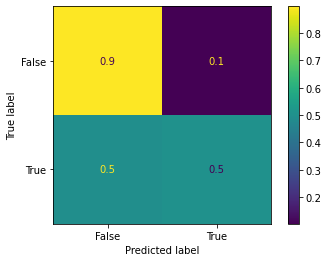

In [125]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

print("\n Confusion Matrix")
plot_confusion_matrix(clf, X_test,y_test, normalize='true')
plt.show()

# Export Classification report

A model without a report is as good as a teleportation machine without a manual.. 

You should not try to use it! 

We must prepare a report and save it with our model

In [ ]:
def prepare_report(cv_score: float, model_params: dict, classification_report: str, columns: List[str], example_data: np.ndarray) -> str:
    '''
    Prepares a training job repor in Text
    
            Parameters:
                    cv_score (float): score of the training job during cross validation of training data
                    model_params (dict): dictonary containing the parameters the model was trained with
                    classification_report (str): Model classification report with test data
                    columns (List[str]): List of columns that where used in training.
                    example_data (np.array): Sample of data (2-3 rows are enough). This is used to include what the prediciton payload should look like for the model
            Returns:
                    report (str): Full report in text
    '''
    
    buffer_example_data = '['
    for r in example_data:
        buffer_example_data+='['
        for c in r:
            if(isinstance(c,str)):
                buffer_example_data+="'"+c+"', "
            else:
                buffer_example_data+=str(c)+", "
        buffer_example_data= buffer_example_data[:-2]+"], \n"
    buffer_example_data= buffer_example_data[:-3]+"]"
        
    report = """
Training Job Report    
    
Cross Validation Score: {cv_score}

Training Model Parameters: {model_params}
    
Test Data Classification Report:
{classification_report}

Example of data array for prediciton:

Order of columns:
{columns}

Example for clf.predict()
{predict_example}


Example of GCP API request body:
{{
    "instances": {json_example}
}}

""".format(
    cv_score=cv_score,
    model_params=json.dumps(model_params),
    classification_report=classification_report,
    columns = columns,
    predict_example = buffer_example_data,
    json_example = json.dumps(example_data.tolist()))
    
    return report

In [ ]:
def report_export_gcs(report: str, report_dir: str) -> None:
    '''
    Exports training job report to GCS
    
            Parameters:
                    report (str): Full report in text to sent to GCS
                    report_dir (str): GCS path to store the report model. i.e gs://example_bucket/training-job
            Returns:
                    export_path (str): Report GCS location
    '''
    scheme, bucket, path, file = process_gcs_uri(report_dir)
    if scheme != "gs:":
            raise ValueError("URI scheme must be gs")
            
    # Upload the model to GCS
    b = storage.Client().bucket(bucket)
    
    export_path = os.path.join(path, 'report.pkl')
    blob = b.blob(export_path)
    
    blob.upload_from_string(report)
    
    return scheme + "//" + os.path.join(bucket, export_path)

In [ ]:
report = prepare_report(cv_score,
                        model_params,
                        classification_report(y_test,y_pred),
                        ALL_COLUMNS, 
                        X_test.to_numpy()[0:2])

report_export_gcs(report, MODEL_DIR)

print(report)

#### Pause... Reflect... and...
### GO BACK TO QWIKLABS :)